# Исследование рынка общепита Москвы


## Шаг 1. Получение данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
from scipy import stats as st
import plotly.express as px
import math as mth

register_matplotlib_converters()

In [4]:
data = pd.read_csv("https://code.s3.yandex.net/datasets/logs_exp.csv",sep="\t")

In [5]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Шаг 2. Подготовка данных

- Заменим названия столбцов на удобные:


In [5]:
data.columns = ['event', 'user', 'timestamp', 'group']

- Проверим наличие пропусков, а также типы данных
- Добавим столбец даты и времени, а также отдельный столбец дат

In [6]:
data.duplicated().sum()

413

In [7]:
data.isna().sum()

event        0
user         0
timestamp    0
group        0
dtype: int64

Выявлено 413 явных дубликатов. Отбросим их. Пропусков не обнаружено.

In [8]:
data = data.drop_duplicates().reset_index(drop = True)

Преобразуем исходный столбец даты к нужному типу данных, а также добавим отдельный столбец с датой (без времени):

In [9]:
data['dt'] = pd.to_datetime(data['timestamp'], unit = 's')

In [10]:
data['date'] = data['dt'].dt.date

In [11]:
data.head()

,event,user,timestamp,group,dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


## Шаг 3. Изучиние и проверка данных

### Сколько всего событий в логе?

In [12]:
data['event'].count()

243713

Данные содержат записи о 243 713 событиях.

### Сколько всего пользователей в логе?

In [13]:
len(data['user'].unique())

7551

Данные содержат информацию о 7 551 уникальном пользователе.

### Сколько в среднем событий приходится на пользователя?

In [14]:
avg_event = data['event'].count() / len(data['user'].unique())
avg_event.round(0)

32.0

In [15]:
data.groupby('user').agg({'event': 'count'}).describe()

,event
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


В среднем на одного пользователя приходится 32 записи о событиях. <br>
Медианное значение - 20. Распределение смещенное влево.<br>
Минимальное количество действий совершаемое пользователями: 1, максимальное - 2307. Есть основания полагать, что в выборке встречаются аномальные пользователи.

### Данными за какой период мы располагаем

Найдем максимальную и минимальную дату: 

In [16]:
data.head()

,event,user,timestamp,group,dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [17]:
data['date'].min()

datetime.date(2019, 7, 25)

In [18]:
data['date'].max()

datetime.date(2019, 8, 7)

Минимальная дата: 25 июля 2019 <br>
Максимальная дата: 7 августа 2019 <br>

Построим гистограмму количества событий по дате и времени:

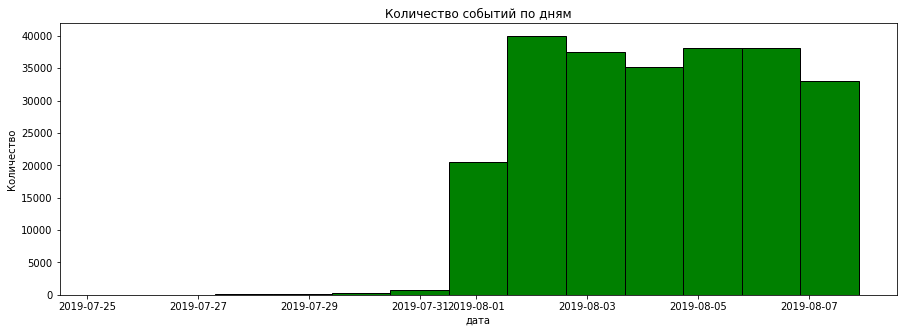

In [19]:
plt.figure(figsize=(15, 5))
plt.hist(data['dt'], color = 'green', edgecolor = 'black', bins=13);
plt.title('Количество событий по дням')
plt.xlabel('дата');
plt.ylabel('Количество');

Вероятно мы не обладаем одинаково полными данными за весь период. Это могло возникнуть из-за того, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».<br> 
Будем использовать данные начинающиеся с 01.08.2019 <br>

Мы располагаем данными с 1 по 7 августа 2019 года.

In [20]:
new_data = data.query('date >= datetime(2019, 8, 1).date()')

In [21]:
minus_event = data['event'].count() - new_data['event'].count()
print('Отброшены записи о', minus_event, 'событиях')
minus_user = len(data['user'].unique()) - len(new_data['user'].unique())
print('Отброшены данные', minus_user, 'пользователей')

Отброшены записи о 2826 событиях
Отброшены данные 17 пользователей


In [22]:
pers_minus_event = (1-(new_data['event'].count() / data['event'].count()))
print('Доля данных, отброшенная после обработки: {:.2%}'.format(pers_minus_event))
pers_minus_user = (1-(len(new_data['user'].unique()) / len(data['user'].unique())))
print('Доля пользователей, отброшенная после обработки данных: {:.2%}'.format(pers_minus_user))

Доля данных, отброшенная после обработки: 1.16%
Доля пользователей, отброшенная после обработки данных: 0.23%


После обработки данных, отброшено приемлемое количество данных (менее 10%)

Отбросив "старые" данные у нас остались записи о 240 887 событиях, совершенных 7 534 пользователями.

In [23]:
new_data['event'].count()

240887

In [24]:
len(new_data['user'].unique())

7534

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп:

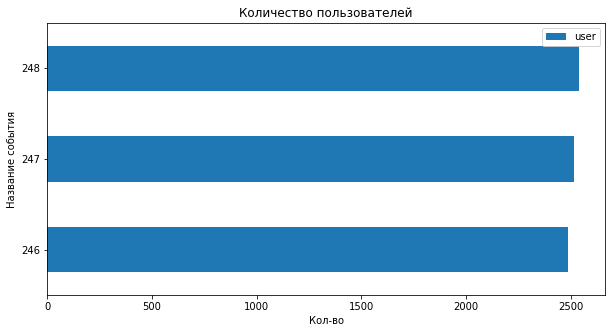

In [25]:
data_group_sorted = new_data.groupby('group').agg({'user':'nunique'})
data_group_sorted.plot(figsize=(10,5), kind="barh");
plt.title('Количество пользователей')
plt.xlabel('Кол-во');
plt.ylabel('Название события');

Данные содержат записи о пользователях всех трех групп, более того, их количество примерно одинаковое - около 2500 пользователей.

## Шаг 4. Воронка событий


### Какие события есть в логах, как часто они встречаются?

Построим диаграмму количества событий. Отсортируем события по частоте.

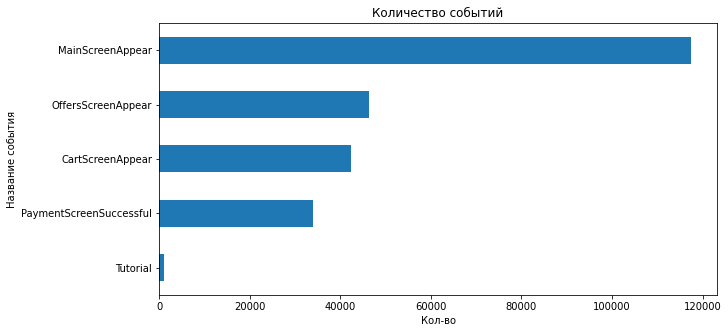

In [26]:
data_sorted = new_data.groupby("event")["user"].count().sort_values()
data_sorted.plot(figsize=(10,5), kind="barh");
plt.title('Количество событий')
plt.xlabel('Кол-во');
plt.ylabel('Название события');

Самым популярным событием является просмотр главного экрана. Самым редким - обучение.

### Сколько пользователей совершали каждое из этих событий?
Отсортируем события по числу пользователей. 

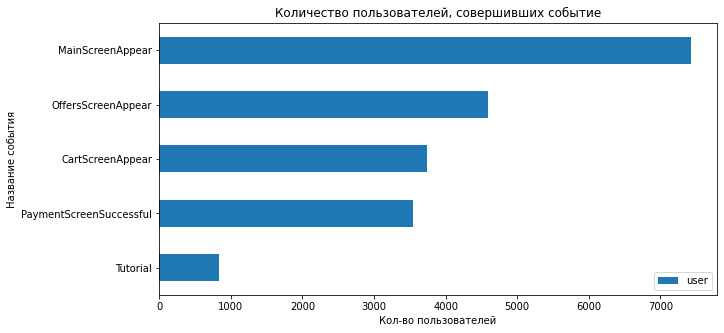

In [27]:
data_sorted_by_group = new_data.groupby('event').agg({'user':'nunique'}).sort_values(by='user', ascending=True)
data_sorted_by_group.plot(figsize=(10,5), kind="barh");
plt.title('Количество пользователей, совершивших событие')
plt.xlabel('Кол-во пользователей');
plt.ylabel('Название события');

### Доля пользователей, которые хоть раз совершали событие.

In [28]:
events_count = new_data.groupby('event').agg({'user':'nunique'}).reset_index().sort_values(by = 'user',ascending = False)
events_count['percent'] = (events_count['user'] / new_data['user'].nunique() * 100).round()
events_count

,event,user,percent
1,MainScreenAppear,7419,98.0
2,OffersScreenAppear,4593,61.0
0,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


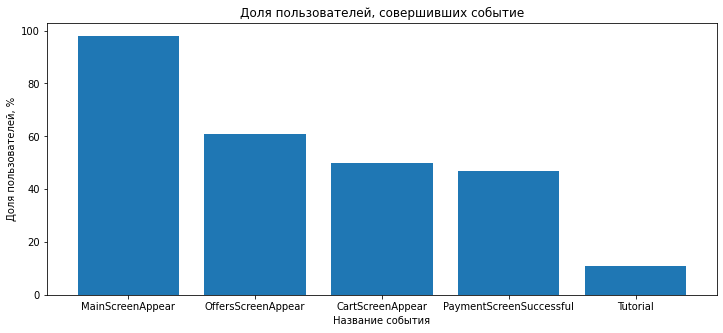

In [29]:
plt.figure(figsize=(12, 5))
plt.bar(events_count['event'], events_count['percent'])
plt.title('Доля пользователей, совершивших событие')
plt.xlabel('Название события');
plt.ylabel('Доля пользователей, %');

Почти 100% открывали главный экран, до успешной оплаты доходили чуть меньше половины от всех пользователей.<br>
Для события MainScreenAppear доля пользователей, его совершивших, составляет 98.5%, возможно это связано с тем, что часть пользователей только посмотрели обучение и не проходили в остальные части приложения. Или, возможно, на некоторые другие события пользователи переходили по ссылкам из браузера минуя главный экран.

### Цепочка событий. 
Предположим, что события происходят в следующем порядке: **Главный экран - Предложение - Корзина - Успешная оплата.** <br>
Обучение вероятнее всего не является обязательным, его можно пропустить и вернуться к нему при необходимости. Обучение очитывать не будем.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

In [30]:
warnings.filterwarnings('ignore') 

In [31]:
funnel = events_count[events_count['event'] != 'Tutorial']
funnel['%_to_prev'] = funnel['user'].shift(1)
funnel.loc[funnel['%_to_prev'].isna(), '%_to_prev'] = funnel.loc[funnel['%_to_prev'].isna(), 'user']
funnel['%_to_prev'] = (funnel['user'] / funnel['%_to_prev'] * 100).round()
funnel = funnel.sort_values(by = 'user', ascending = False)
funnel

,event,user,percent,%_to_prev
1,MainScreenAppear,7419,98.0,100.0
2,OffersScreenAppear,4593,61.0,62.0
0,CartScreenAppear,3734,50.0,81.0
3,PaymentScreenSuccessful,3539,47.0,95.0


После просмотра главного экрана теряется больше всего пользователей.<br>
До последнего события доходит лишь 47 % пользователей.

## Шаг 5. Изучите результаты эксперимента


### Сколько пользователей в каждой экспериментальной группе?


In [32]:
visitors248 = new_data[new_data['group'] == 248]['user']
print('Количество пользователей в группе 248:', visitors248.nunique())
visitors247 = new_data[new_data['group'] == 247]['user']
print('Количество пользователей в группе 247:', visitors247.nunique())
visitors246 = new_data[new_data['group'] == 246]['user']
print('Количество пользователей в группе 246:', visitors246.nunique())

Количество пользователей в группе 248: 2537
Количество пользователей в группе 247: 2513
Количество пользователей в группе 246: 2484


Проверим, есть ли пользователи, которые попали в несколько групп, так как они могут оказать влияние на результаты теста:

In [33]:
visitors246 = new_data[new_data['group'] == 246]['user']
visitors247 = new_data[new_data['group'] == 247]['user']
visitors248 = new_data[new_data['group'] == 248]['user']

visitors246and247 = pd.Series(np.intersect1d(visitors246, visitors247))
visitors246and248 = pd.Series(np.intersect1d(visitors246, visitors248))
visitors247and248 = pd.Series(np.intersect1d(visitors247, visitors248))

print('Пользователи, попавшие в несколько групп:',len(visitors246and247) + len(visitors246and248) + len(visitors246and248))

Пользователи, попавшие в несколько групп: 0


Пользователей, попавших в несколько групп не выявлено.

### A/A эксперимент

Используем данные 2 контрольных групп для А/А-эксперимента. Проверим корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.<br>
Возьмем самое популярное событие: MainScreenAppear. <br>
Посчитаем число и долю пользователей, совершивших это событие в каждой из контрольных групп. 

In [34]:
piv = new_data.pivot_table(index='event',columns='group', values = 'user', aggfunc = 'nunique')
piv

group,246,247,248
event,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


In [35]:
print('Доля пользователей группы 246, совершивших действие "MainScreenAppear":', round((2450 *100 / 2484), 2), '%')
print('Доля пользователей группы 247, совершивших действие "MainScreenAppear":', round((2476 *100 / 2513),2), '%')

Доля пользователей группы 246, совершивших действие "MainScreenAppear": 98.63 %
Доля пользователей группы 247, совершивших действие "MainScreenAppear": 98.53 %


Проверим, будет ли отличие между группами статистически достоверным. <br>
Для начала зададим функцию для проведения тестирования:

In [36]:
def z_test(n1, x1, n2, x2, alpha):

    p1 = x1 / n1
    p2 = x2 / n2
    
    p_combined = (x1 + x2) / (n1 + n2)
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

 Проверим статистическую достоверность различий по событию " MainScreenAppear". <br>
Сформулируем гипотезы. Нулевая: различий между группами нет. Альтернативная: различия между группами есть.

In [37]:
z_test(
    visitors246.nunique(),
    piv.query('event == "MainScreenAppear"')[246],
    visitors247.nunique(),
    piv.query('event == "MainScreenAppear"')[247],
    0.00625,
)

p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим статистическую достоверность различий по остальным событиям. Гипотезы аналогичны.<br>
OffersScreenAppear:

In [38]:
z_test(
    visitors246.nunique(),
    piv.query('event == "OffersScreenAppear"')[246],
    visitors247.nunique(),
    piv.query('event == "OffersScreenAppear"')[247],
    0.00625,
)

p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


CartScreenAppear:

In [39]:
z_test(
    visitors246.nunique(),
    piv.query('event == "CartScreenAppear"')[246],
    visitors247.nunique(),
    piv.query('event == "CartScreenAppear"')[247],
    0.00625,
)

p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


PaymentScreenSuccessful	:

In [40]:
z_test(
    visitors246.nunique(),
    piv.query('event == "PaymentScreenSuccessful"')[246],
    visitors247.nunique(),
    piv.query('event == "PaymentScreenSuccessful"')[247],
    0.00625,
)

p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ни по одному из событий не получилось отвергнуть нулевую гипотезу. Группы одинаковые. 

### A1/B - эксперимент

Аналогично проверим статистическую значимость различий между группами 246 и 248. <br>
Сформулируем гипотизы. Нулевая: различий между группами нет. Альтернативная: различия между группами есть. <br>
- по событию " MainScreenAppear"

In [41]:
z_test(
    visitors246.nunique(),
    piv.query('event == "MainScreenAppear"')[246],
    visitors248.nunique(),
    piv.query('event == "MainScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [42]:
visitors246.nunique()

2484

- по событию OffersScreenAppear:

In [43]:
z_test(
    visitors246.nunique(),
    piv.query('event == "OffersScreenAppear"')[246],
    visitors248.nunique(),
    piv.query('event == "OffersScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- по событию CartScreenAppear:

In [44]:
z_test(
    visitors246.nunique(),
    piv.query('event == "CartScreenAppear"')[246],
    visitors248.nunique(),
    piv.query('event == "CartScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- по событию PaymentScreenSuccessful:

In [45]:
z_test(
    visitors246.nunique(),
    piv.query('event == "PaymentScreenSuccessful"')[246],
    visitors248.nunique(),
    piv.query('event == "PaymentScreenSuccessful"')[248],
    0.00625,
)

p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


*Для alpha = 0.1:* Проведя тесты можно сказать, что по трем событиям между группами 246 и 248 нет разницы. Вслучае с CartScreenAppear мы можем отвергнуть нулевую гипотезу.

*С учетом поправки:* Ни по одному из событий не получилось отвергнуть нулевую гипотезу. 

### A2/B - эксперимент

Аналогично проверим статистическую значимость различий между группами 247 и 248.
Сформулируем гипотизы. Нулевая: различий между группами нет. Альтернативная: различия между группами есть.

- по событию " MainScreenAppear"

In [46]:
z_test(
    visitors247.nunique(),
    piv.query('event == "MainScreenAppear"')[247],
    visitors248.nunique(),
    piv.query('event == "MainScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- по событию OffersScreenAppear:

In [47]:
z_test(
    visitors247.nunique(),
    piv.query('event == "OffersScreenAppear"')[247],
    visitors248.nunique(),
    piv.query('event == "OffersScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- по событию CartScreenAppear:

In [48]:
z_test(
    visitors247.nunique(),
    piv.query('event == "CartScreenAppear"')[247],
    visitors248.nunique(),
    piv.query('event == "CartScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- по событию PaymentScreenSuccessful:

In [49]:
z_test(
    visitors247.nunique(),
    piv.query('event == "PaymentScreenSuccessful"')[247],
    visitors248.nunique(),
    piv.query('event == "PaymentScreenSuccessful"')[248],
    0.00625,
)

p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По всем 4 событиям отвергнуть нулевую гипотезу не получилось. Группы равны.

### A1+A2/B - эксперимент

Проведем эксперимент с объединённой контрольной группой (246+247). <br> 
Сформулируем гипотизы. Нулевая: различий между группами нет. Альтернативная: различия между группами есть.

- по событию " MainScreenAppear":

In [50]:
z_test(
    visitors246.nunique()+ visitors247.nunique(),
    piv.query('event == "MainScreenAppear"')[247] + piv.query('event == "MainScreenAppear"')[246] ,
    visitors248.nunique(),
    piv.query('event == "MainScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- по событию OffersScreenAppear:

In [51]:
z_test(
    visitors246.nunique()+ visitors247.nunique(),
    piv.query('event == "OffersScreenAppear"')[247] + piv.query('event == "OffersScreenAppear"')[246] ,
    visitors248.nunique(),
    piv.query('event == "OffersScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- по событию CartScreenAppear:

In [52]:
z_test(
    visitors246.nunique()+ visitors247.nunique(),
    piv.query('event == "CartScreenAppear"')[247] + piv.query('event == "CartScreenAppear"')[246] ,
    visitors248.nunique(),
    piv.query('event == "CartScreenAppear"')[248],
    0.00625,
)

p-значение:  [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- по событию PaymentScreenSuccessful:

In [53]:
z_test(
    visitors246.nunique()+ visitors247.nunique(),
    piv.query('event == "PaymentScreenSuccessful"')[247] + piv.query('event == "PaymentScreenSuccessful"')[246] ,
    visitors248.nunique(),
    piv.query('event == "PaymentScreenSuccessful"')[248],
    0.00625,
)

p-значение:  [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Не получилось отвергнуть нулевую гипотезу ни по одному событию.

Итак, нами было выполнено 16 проверок. <br>
Изначально в проверках уровень значимости установлен на уровне - 0.1. Мы знаем, что, чем меньше уровень значимости, тем меньше риск ошибочно отвергнуть нулевую гипотезу. Так, при уровне значимости 0.1 каждый десятый раз можно получать ложный результат. <br>
Результаты при уровне значимости 0.1: в 15 из 16 экспериментов не получилось отвергнуть нулевую гипотезу.
<br>

При выборе уровня значимости необходимо исходить, из того, что в случае увеличения количества групп в тесте растёт и вероятность ошибки первого рода. В нашем случае при наличии 3 групп: 1 - (1 - 0.1)^3 = 0.271 или 27.1%<br>
Для устранения этого эффекта применим поправку Бонферрони, деля уровень значимости 0.1 на количество проведённых экспериментов (в нашем случае на 16): 0.1/16 = 0,00625. <br>
После проведения новых расчетов получены результаты: не получилось отвергнуть нулевую гипотезу ни в одном из 16 экспериментов.<br>
Кроме того, необходимо отметить, что полученные в ходе проведения тестов значения p-values слишком высоки, чтобы отклонить хоть одну нулевую гипотезу даже при скорректированном уровне значимости.

## Вывод

Мы изучили представленные данные, очистили их от дубликатов, проверили на наличие пропусков. Подготовили данные к работе.

Сформулировали, как выглядит воронка: Главный экран - Предложение - Корзина - Успешная оплат. Чаще всего пользователи просматривают главный экран. Реже всего просматривается экран с обучением (при проведении экспериментов данный этап не учитывался). Конверсия в воронке выглядит так: 100% - 62% - 81% - 95%. При это до покупки доходят 47% от общего числа посльзователей.

Нами так же были изучены результаты эксперимента и проведены тесты на наличие статистически значимых отличий между группами. По результатам A/A/B-эксперимента можно сделать вывод, что изменение шрифта не влияет на поведение пользователей, так как при уровне значимости 0.1 (*с учетом поправки Бонфероррони: 0.00625*) отвергнуть гипотезу о том, что в группах есть существенные различия, не получилось практически по всех тестах. 